In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from pandas import Series
from scipy.interpolate import interp1d
from pandas import Series
import re

In [30]:
df = pd.read_csv("厦门租房数据.csv") 

载入已经从某租房网站爬取下来的租房信息,爬虫用到的第三方库为requests_html

In [31]:
print("数据分布情况")
print(df.info())
print("=======================================")
print("检测缺失值:")
print(df.isnull().sum())
print("=======================================")
print("房租价格描述性统计:")
print(df["出租价格"].describe())
print("=======================================")
print("房屋面积描述性统计")
print(df["房屋面积"].describe())
print("=======================================")

数据分布情况
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10827 entries, 0 to 10826
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   房屋编号    10827 non-null  object
 1   小区名称    10827 non-null  object
 2   小区地址    10827 non-null  object
 3   出租方式    10827 non-null  object
 4   房屋面积    10827 non-null  object
 5   房屋朝向    10827 non-null  object
 6   户型结构    10827 non-null  object
 7   所在楼层    10827 non-null  object
 8   出租价格    10827 non-null  int64 
 9   房屋优点    10104 non-null  object
 10  详情链接    10827 non-null  object
dtypes: int64(1), object(10)
memory usage: 930.6+ KB
None
检测缺失值:
房屋编号      0
小区名称      0
小区地址      0
出租方式      0
房屋面积      0
房屋朝向      0
户型结构      0
所在楼层      0
出租价格      0
房屋优点    723
详情链接      0
dtype: int64
房租价格描述性统计:
count     10827.000000
mean       3593.057080
std        7159.888806
min         500.000000
25%        1500.000000
50%        2500.000000
75%        4000.000000
max      288000.000000
Name: 出租价格,

先大致看下数据的基本信息

In [32]:
df.drop_duplicates("房屋编号",keep="first", inplace=True)

对数据集去重，进入数据预处理流程

In [33]:
df['房屋面积'] = [int(re.search('\d', i).group()) for i in df['房屋面积']]
df['房屋面积'] = df['房屋面积'].astype('int')
df['所在楼层'] = [int(re.search('\d', i).group()) for i in df['所在楼层']]
print(df['房屋面积'])

0        1
1        6
2        2
3        3
4        1
        ..
10822    1
10823    1
10824    1
10825    2
10826    7
Name: 房屋面积, Length: 4904, dtype: int32


简单清洗数据，对数据类型进行转换用以运算

处理异常值(高斯分布)
异常点个数为： 0
异常点最大值为： nan
异常点最小值为： nan
处理异常值(箱线图)


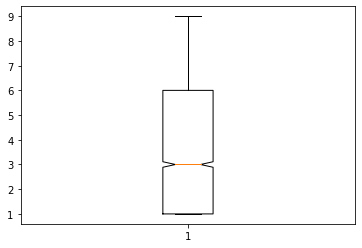

异常点个数为： 0


In [34]:
def out_range(series):
    boolInd = (series.mean() - 3 * series.std() > series) | (series.mean() + 3 * series.std() < series)
    index = np.arange(series.shape[0])[boolInd]
    out = series.iloc[index]
    return out


print("处理异常值(高斯分布)")
outlier = out_range(df['房屋面积'])
print("异常点个数为：", outlier.shape[0])
print("异常点最大值为：", outlier.max())
print("异常点最小值为：", outlier.min())

print("=======================================")
print("处理异常值(箱线图)")
p = plt.boxplot(df['房屋面积'], notch=True)
outlier = p['fliers'][0].get_ydata()
plt.show()
print("异常点个数为：", outlier.shape[0])
if len(outlier)> 0:
    print("异常点最大值为：", outlier.max())
    print("异常点最小值为：", outlier.min())

print("=======================================")

处理数据集异常值，不过这两种方法的效果不是很好，因为数据集的值相差不大难以准确识别

In [37]:
def func_mahalanobis(df, n_outliers):


    m_dist_order = Series([float(distance.mahalanobis(df[['房屋面积', '出租价格']].iloc[i], df[['房屋面积', '出租价格']].mean(),
                                                      np.mat(df[['房屋面积', '出租价格']].cov().values).I) ** 2)
                           for i in range(len(df))]).sort_values(ascending=False).index.tolist()


    error_index = m_dist_order[:n_outliers]
    error = df[['房屋面积', '出租价格']].iloc[error_index]

    return error
outlier = func_mahalanobis(df, 500)
print("处理异常值(马氏距离)")
print("异常点个数为：", outlier.shape[0])
print("异常点最大值为：", outlier.max()[0])
print("异常点最小值为：", outlier.min()[0])




处理异常值(马氏距离)
异常点个数为： 500
异常点最大值为： 9
异常点最小值为： 1


这里使用马氏距离处理异常值，因为马氏距离能考虑到各种特性之间的联系，这样离群点就被成功分离

In [39]:
df['所在楼层'] = df['所在楼层'].astype('int')
isNearSubway = []
for i in df['房屋优点']:
    if "近地铁" in str(i):
        isNearSubway.append(1)
    else:
        isNearSubway.append(0)
df['邻近地铁'] = isNearSubway
area = list(set(df['小区地址']))
classArea = {}
for i in range(len(area)):
    classArea[area[i]] = i
newArea = []
for i in df['小区地址']:
    newArea.append(classArea.get(i))
df['位置编号'] = newArea
print('相关系数矩阵为：')
print(np.round(df.corr(method='pearson'), 2), )

print("=======================================")

相关系数矩阵为：
      房屋面积  所在楼层  出租价格  邻近地铁  位置编号
房屋面积  1.00  0.07 -0.06 -0.00 -0.02
所在楼层  0.07  1.00 -0.04  0.04 -0.01
出租价格 -0.06 -0.04  1.00  0.02 -0.02
邻近地铁 -0.00  0.04  0.02  1.00  0.05
位置编号 -0.02 -0.01 -0.02  0.05  1.00


这里选取房屋面积、所在楼层、邻近地铁、以及地理位置进行皮尔斯相关系数法分析计算，可以看出房源的出租价格跟房屋面积最为相关，相关系数r为0.78属于强线性关系。

注:肯基尔相关系数一般是变量分布均匀的情况下使用，把变量进行逐一配对，如果变量存在变化趋势相同，那说明变量间存在相关性；斯皮尔曼秩相关法，是非参数检验的一种方法，它利用秩的大小对变量进行分析，秩是数据按照升幂后的值进行排序，秩的位置决定了观测值的位置；皮尔森相关系数分析用来描述特征间的线性强度关系，计算方法和斯皮尔曼秩相关法相差无几，是最简单相关系数表示方法。当0<r<1时表示正相关，并且值越大相关关系越强，在0.5以上是强线性相关，0.3到0.5之是中等相关，0.1到0.3是轻微系数相关，0.09以下可以忽略不计认为它们不相关。

Text(0.5, 1.0, '房屋面积和房租散点图')

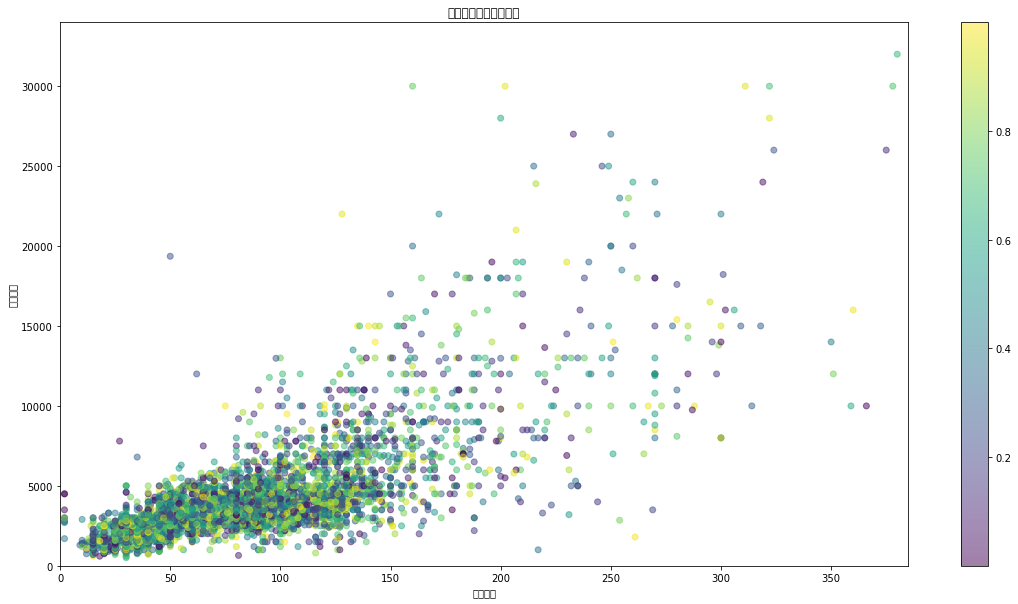

In [35]:
N = len(df)
colors = np.random.rand(N)

plt.figure(figsize=(19, 10))
plt.xlim(0, 385)
plt.ylim(0, 34000)
plt.scatter(df['房屋面积'], df['出租价格'], c=colors, alpha=0.5)
plt.colorbar()
plt.xlabel('房屋面积')
plt.ylabel('每月租金')
plt.title('房屋面积和房租散点图')

在房源的出租价格和房屋面积的散点图中，可以看出它们二者呈现出关联趋势。面积相对于租金来说以相对密集的上升趋势出现，由此可以断定它们具有相关性，下一步要对其相关系数进一步求解验证。

计算出来的值 a=73.6,b=-1882.6
回归方程为，y = 73.6*x  + -1882.6


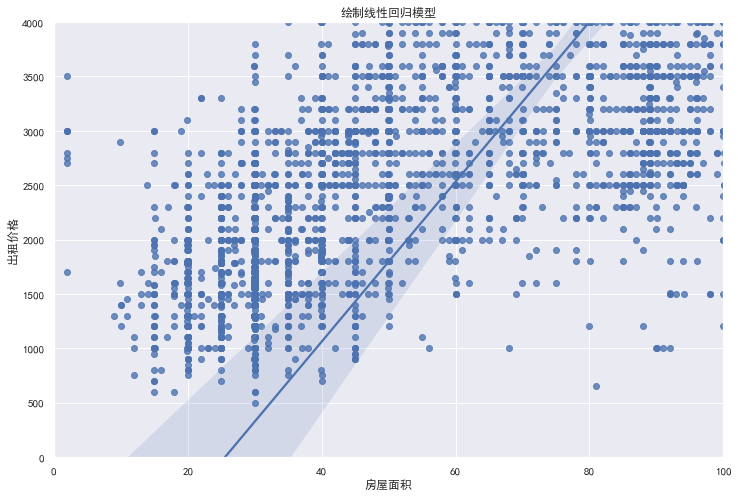

In [36]:
sns.set_theme(color_codes=True)
fig = plt.figure(figsize=(12, 8))
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.title("绘制线性回归模型")
sns.regplot(x="房屋面积", y="出租价格", data=df,x_jitter=.05)
plt.xlim(0, 100)
plt.ylim(0, 4000)
plt.savefig("绘制线性回归模型.png")
from sklearn.linear_model import LinearRegression
model = LinearRegression()
xtrain = df['房屋面积']
ytrain = df['出租价格']
model.fit(np.array(xtrain).reshape(-1,1),np.array(ytrain))
model.coef_
model.intercept_
print('计算出来的值 a=%.1f,b=%.1f'%(model.coef_,model.intercept_))
print('回归方程为，y = %.1f*x  + %.1f'%(model.coef_,model.intercept_))

前面已经验证了房租和房屋面积具有相关性，那么二者有着怎样的线性关系，这是回归分析所关心的，这种关系被称为模型。一般使用的是最小二乘法绘制回归线，在各个点残差相同的条件下拟合出一条直线，这里使用95%的置信区间并且向散点添加噪音来绘制回归线。可见价格与面积存在一定线性关系，即每增加一平方米面积租金增加25.2元。

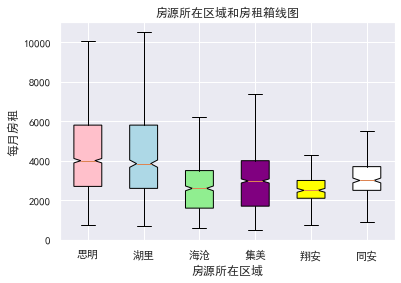

In [46]:
df['小区地址'] = df['小区地址'].str.split('-').str[0]
region = ['思明', '湖里', '海沧', '集美', '翔安', '同安']
mean_money = []
region_money = []
for i in region:
    money = df.groupby(by="小区地址").get_group(i)['出租价格']
    region_money.append(money)
    mean_money.append(np.mean(money))
region_money = np.array(region_money, dtype=object)
bplot = plt.boxplot(region_money, notch=True, labels=region, meanline=True, showfliers=False, patch_artist=True)
plt.title('房源所在区域和房租箱线图')
colors = ['pink', 'lightblue', 'lightgreen', 'purple', 'yellow', 'white']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('房源所在区域')
plt.ylabel('每月房租')
plt.show()

可以看出厦门市的湖里区房源数量最多，思明区的房源数量比湖里区略低，并且这两个地区的租金跨度范围最大，整体价格水平也是最高的地区。这可能是受到其地理位置的影响，思明区和湖里区在厦门岛内，其他4个地区在岛外，远离市中心。其中海沧区箱体下沿最低，均值也处于全市最低水平。翔安区的房源租金波动最为平稳，大部分房源租金价格处于均值以下

利用现有的数据集还可以挖下房源的其他特征情况，例如房源的房屋朝向、房屋结构、房源到地铁站距离远近以及房源所在楼层高度和租金关联程度等，这里就不一一展开细说了。在数据分析中，看待事物的角度不是单一的，很多数据实际上是有关联的。不能简单的用几个指标来衡量，继而对数据的事实下结论。正确的做法是要对数据的各个方面进行高度概括，综合考量。